In [3]:
%%capture
!pip install langgraph langchain openai

In [4]:
%%capture
!pip install langgraph langchain langchain-community langchain-core openai

In [6]:
%%capture
!pip install langchain-openai

In [34]:
%%capture
!pip install langchain-groq

In [93]:
%%capture
!pip install fpdf

In [150]:
%%capture
!pip install gradio # install gradio

In [ ]:
import os

os.environ["OPENAI_API_KEY"] = ""

In [135]:
import sys
import io
import os
from typing import TypedDict, Literal, List
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
import re
from IPython.display import display, Image, Markdown
from langchain_core.runnables.graph import MermaidDrawMethod
import operator
from langchain_groq import ChatGroq


In [ ]:
os.environ["GROQ_API_KEY"] = ""

In [137]:
# llm = ChatOpenAI(model="gpt-4", temperature=0)
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="mixtral-8x7b-32768",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [152]:
class ResercherState(TypedDict):
    """State of the graph."""

    user_input: str
    plan: str
    sources: str
    analysis: str
    report: str
    pdf_saved: str

In [153]:
def planner_agent(state: ResercherState):
    """Break down the research topic into structured objectives with detailed guidance."""
    print("--Calling Planner Agent--")

    prompt = ChatPromptTemplate.from_template(
        """You are an expert research planner with extensive experience in structuring research projects. Your task is to analyze the given research query and break it down into a well-organized set of research objectives.

        Consider the following when forming the objectives:
        - Identify the key themes and subtopics within the query.
        - Ensure each objective contributes to a logical research progression.
        - Frame objectives clearly, using action-oriented language (e.g., "Analyze...", "Investigate...", "Develop...").
        - If applicable, suggest methodologies or approaches relevant to achieving the objectives.
        - Maintain clarity and conciseness in structuring the objectives.

        Query: {query}

        Provide a structured list of research objectives as the response.
        """
    )

    chain = prompt | llm
    plan = chain.invoke({"query": state["user_input"]}).content
    return {"plan": plan}


In [154]:
# def retriever_agent(state: ResercherState):
#     """Retrieve relevant and high-quality sources for the research plan, ensuring credibility and relevance."""

#     prompt = ChatPromptTemplate.from_template(
#         """You are an expert research assistant specializing in retrieving high-quality and credible sources for academic and technical research.
#         Your task is to find the most relevant sources based on the given research objectives.

#         When selecting sources, consider the following:
#         - Prioritize peer-reviewed academic papers, conference proceedings, and reputable journal articles.
#         - Include authoritative books, government reports, and industry white papers if relevant.
#         - Identify trusted websites, such as university research pages and established institutions.
#         - Ensure sources are up-to-date and relevant to the objectives.
#         - Provide proper citation details (e.g., title, author(s), publication year, source link if available).

#         Research Objectives:
#         {plan}

#         Provide a structured list of sources, including brief descriptions of their relevance.
#         """
#     )

#     chain = prompt | llm
#     sources = chain.invoke({"plan": state["plan"]}).content
#     return {"sources": sources}
def retriever_agent(state: ResercherState):
    """Retrieve relevant and high-quality sources for the research plan, ensuring credibility and relevance."""
    print("--Calling Retriever Agent--")

    prompt = ChatPromptTemplate.from_template(
        """You are an expert research assistant specializing in retrieving only **authentic, high-quality, and verifiable** sources for academic and technical research.
        Your task is to find **real, credible, and properly cited** sources that are directly relevant to the given research objectives.

        **Strict Selection Criteria for Sources:**
        - **Peer-Reviewed and Verified**: Prioritize academic papers published in **reputable journals**, conference proceedings, and trusted research institutions.
        - **Official and Authoritative**: Include government reports, university research pages, industry white papers, and books from recognized publishers.
        - **Up-to-Date and Relevant**: Ensure that sources are **recent** and **directly related** to the research objectives.
        - **NO Hallucinated or Fake Sources**: Every source must be **real, traceable, and properly cited** (e.g., with DOI, ISBN, or official website links).
        - **No General Blogs, Forums, or Unverified Articles**: Only use sources that are widely accepted in academia or industry.

        **Research Objectives:**
        {plan}

        **Expected Output:**
        - A **structured, verifiable list** of **real sources**, including:
          - **Title** (must match the actual publication title)
          - **Author(s)**
          - **Publication Year**
          - **Source Type** (e.g., journal, conference, government report, book)
          - **Official Citation or DOI/URL** (if available)
        - A **brief explanation** of why each source is relevant.

        If you cannot find verified sources, explicitly state: *"No credible sources found for this query."* Do **not** generate any fabricated sources.
        """
    )

    chain = prompt | llm
    sources = chain.invoke({"plan": state["plan"]}).content
    return {"sources": sources}


In [155]:
def critic_agent(state: ResercherState):
    """Evaluate the credibility, reliability, and potential biases in the provided sources."""
    print("--Calling Critic Agent--")

    prompt = ChatPromptTemplate.from_template(
        """You are an expert research analyst with extensive experience in evaluating the credibility and reliability of academic and technical sources.
        Your task is to critically assess the given sources based on the following criteria:

        Evaluation Criteria:
        1. Credibility – Assess the reputation of the source (e.g., peer-reviewed journal, government report, university-affiliated research, etc.).
        2. Reliability – Determine whether the source is well-cited, fact-based, and supported by strong evidence.
        3. Potential Biases – Identify any affiliations, funding sources, or ideological perspectives that might introduce bias.
        4. Timeliness – Evaluate whether the source is up-to-date and relevant to the current state of research.
        5. Objectivity & Accuracy – Analyze whether the source presents balanced arguments and avoids misinformation.

        Sources to Evaluate:
        {sources}

        Expected Output:
        - A structured evaluation for each source, highlighting strengths and weaknesses.
        - A summary statement on the overall reliability of the sources provided.
        """
    )

    chain = prompt | llm
    analysis = chain.invoke({"sources": state["sources"]}).content
    return {"analysis": analysis}


In [156]:
import re
from fpdf import FPDF
from datetime import datetime

class PDFReport(FPDF):
    def header(self):
        """Customize the header for each page (except the first cover page)."""
        if self.page_no() > 1:
            self.set_font("Times", "B", 12)
            self.cell(0, 10, "Research Report", ln=True, align="C")
            self.ln(5)

    def footer(self):
        """Customize the footer with page numbers."""
        self.set_y(-15)
        self.set_font("Times", "I", 12)
        self.cell(0, 10, f"Page {self.page_no()}", align="C")

def clean_text(text):
    """Removes all asterisks (*) from the text."""
    return re.sub(r"\*", "", text)


def save_report_as_pdf(report_text: str, filename: str = "research_report.pdf"):
    """Generate a PDF report with a cover page and table of contents."""
    pdf = PDFReport()
    pdf.set_auto_page_break(auto=True, margin=15)

    # Cover Page
    pdf.add_page()
    pdf.set_font("Times", "B", 15)
    pdf.cell(200, 20, "Research Report", ln=True, align="C")
    pdf.ln(10)

    pdf.set_font("Times", "", 12)
    pdf.cell(200, 15, f"Date: {datetime.today().strftime('%B %d, %Y')}", ln=True, align="C")
    pdf.ln(20)

    pdf.set_font("Times", "I", 12)
    pdf.cell(200, 15, "Prepared by: Abdullahi Ahmad", ln=True, align="C")

    pdf.add_page()  # Move to the TOC page

    # Table of Contents
    pdf.set_font("Times", "B", 15)
    pdf.cell(200, 20, "Table of Contents", ln=True, align="C")
    pdf.ln(10)

    sections = ["Introduction", "Key Findings", "Analysis & Discussion", "Conclusion", "References"]
    pdf.set_font("Times", "", 15)

    for i, section in enumerate(sections, start=1):
        pdf.cell(0, 10, f"{i}. {section}", ln=True)
    pdf.ln(10)

    pdf.add_page()  # Move to main content

    # Add Report Content
    pdf.set_font("Times", "", 20)
    report_text = clean_text(report_text)  # Remove formatting like '**'

    for line in report_text.split("\n"):
        if any(title in line for title in sections):
            pdf.set_font("Times", "B", 24)  # Bold and Larger for Titles
        else:
            pdf.set_font("Times", "", 20)  # Normal for body text

        pdf.multi_cell(0, 10, line, align="J")  # Justified text
        pdf.ln(3)

    # Save PDF
    pdf.output(filename)

def writer_agent(state: ResercherState):
    """Summarize the research findings into a well-structured and coherent report and save it as a formatted PDF document."""
    print("--Calling Writer Agent--")

    prompt = ChatPromptTemplate.from_template(
        """You are an expert research writer with experience in crafting structured, concise, and well-organized reports.
        Your task is to summarize the research findings based on the provided analysis and generate a comprehensive report.

        **Guidelines for Writing the Report:**
        1. Title – Provide a clear and concise title for the report.
        2. Introduction – Briefly introduce the research topic, its significance, and objectives.
        3. Key Findings – Summarize the critical insights derived from the research, highlighting credibility, reliability, and biases of sources.
        4. Analysis & Discussion – Present an in-depth evaluation of the findings, discussing patterns, trends, and implications.
        5. Conclusion – Offer a concise conclusion summarizing key takeaways.
        6. References – If applicable, list the most relevant and credible sources used.

        **Analysis Provided:**
        {analysis}

        **Expected Output:**
        - A structured and well-articulated research summary.
        - Logical flow with clear section headings.
        - Objective, concise, and professional writing.
        """
    )

    chain = prompt | llm
    report = chain.invoke({"analysis": state["analysis"]}).content

    # Save the report as a properly formatted PDF
    save_report_as_pdf(report)

    return {"report": report, "pdf_saved": "research_report.pdf"}


In [157]:
# from fpdf import FPDF

# def save_report_as_pdf(report_text: str, filename: str = "research_report.pdf"):
#     """Save the generated research report as a PDF file."""
#     pdf = FPDF()
#     pdf.set_auto_page_break(auto=True, margin=15)
#     pdf.add_page()
#     pdf.set_font("Arial", style='', size=12)

#     # Add title
#     pdf.set_font("Arial", style='B', size=16)
#     pdf.cell(200, 10, "Research Report", ln=True, align='C')
#     pdf.ln(10)  # Line break

#     # Add report content
#     pdf.set_font("Arial", style='', size=12)
#     for line in report_text.split("\n"):
#         pdf.multi_cell(0, 8, line)
#         pdf.ln(1)

#     # Save as PDF
#     pdf.output(filename)

In [158]:
# # def writer_agent(state: ResercherState):
# #     """Summarize the research findings into a well-structured and coherent report."""

# #     prompt = ChatPromptTemplate.from_template(
# #         """You are an expert research writer with experience in crafting structured, concise, and well-organized reports.
# #         Your task is to summarize the research findings based on the provided analysis and generate a comprehensive report.

# #         Guidelines for Writing the Report:
# #         1. Title – Provide a clear and concise title for the report.
# #         2. Introduction – Briefly introduce the research topic, its significance, and objectives.
# #         3. ey Findings – Summarize the critical insights derived from the research, highlighting credibility, reliability, and biases of sources.
# #         4. Analysis & Discussion** – Present an in-depth evaluation of the findings, discussing patterns, trends, and implications.
# #         5. Conclusion – Offer a concise conclusion summarizing key takeaways.
# #         6. References – If applicable, list the most relevant and credible sources used.

# #         Analysis Provided:
# #         {analysis}

# #         Expected Output:
# #         - A structured and well-articulated research summary.
# #         - Logical flow with clear section headings.
# #         - Objective, concise, and professional writing.
# #         """
# #     )

# #     chain = prompt | llm
# #     report = chain.invoke({"analysis": state["analysis"]}).content
# #     return {"report": report}
# def writer_agent(state: ResercherState):
#     """Summarize the research findings into a well-structured and coherent report and save it as a PDF document."""

#     prompt = ChatPromptTemplate.from_template(
#         """You are an expert research writer with experience in crafting structured, concise, and well-organized reports.
#         Your task is to summarize the research findings based on the provided analysis and generate a comprehensive report.

#         **Guidelines for Writing the Report:**
#         1. **Title** – Provide a clear and concise title for the report.
#         2. **Introduction** – Briefly introduce the research topic, its significance, and objectives.
#         3. **Key Findings** – Summarize the critical insights derived from the research, highlighting credibility, reliability, and biases of sources.
#         4. **Analysis & Discussion** – Present an in-depth evaluation of the findings, discussing patterns, trends, and implications.
#         5. **Conclusion** – Offer a concise conclusion summarizing key takeaways.
#         6. **References** – If applicable, list the most relevant and credible sources used.

#         **Analysis Provided:**
#         {analysis}

#         **Expected Output:**
#         - A structured and well-articulated research summary.
#         - Logical flow with clear section headings.
#         - Objective, concise, and professional writing.
#         """
#     )

#     chain = prompt | llm
#     report = chain.invoke({"analysis": state["analysis"]}).content

#     # Save the report as a PDF
#     save_report_as_pdf(report)

#     return {"report": report, "pdf_saved": "research_report.pdf"}


In [159]:
# Define Graph
workflow = StateGraph(ResercherState)
workflow.add_node("planner", planner_agent)
workflow.add_node("retriever", retriever_agent)
workflow.add_node("critic", critic_agent)
workflow.add_node("writer", writer_agent)

# Define workflow edges
workflow.add_edge("planner", "retriever")
workflow.add_edge("retriever", "critic")
workflow.add_edge("critic", "writer")

# Define input/output
workflow.set_entry_point("planner")
workflow.set_finish_point("writer")
app = workflow.compile()

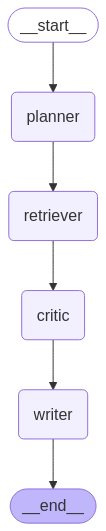

In [160]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [161]:
inputs = {"user_input": "Impact of AI on Personalized Education"}



In [162]:
# Invoke the graph with the input
result = app.invoke(inputs)

--Calling Planner Agent--
--Calling Retriever Agent--
--Calling Critic Agent--
--Calling Writer Agent--


In [163]:
result

{'user_input': 'Impact of AI on Personalized Education',
 'plan': '1. Analyze the current state of AI technology and its applications in the education sector.\n2. Investigate the concept of personalized education and its traditional methods of implementation.\n3. Develop a clear understanding of how AI can be integrated into personalized education systems.\n4. Evaluate the potential benefits and drawbacks of using AI in personalized education.\n5. Assess the impact of AI-driven personalized education on student performance and engagement.\n6. Compare the effectiveness of AI-driven personalized education with traditional methods.\n7. Investigate ethical considerations and potential biases in AI-driven personalized education systems.\n8. Explore future research directions and improvements for AI-driven personalized education.\n9. Formulate recommendations for the successful implementation of AI in personalized education.\n\nMethodologies and approaches:\n- Literature review to gather exi

In [164]:
Markdown(result["sources"])

**Source 1:**
Title: "Artificial Intelligence in Education: Review and Future Directions"
Authors: Romero, C., & Ventura, S.
Publication Year: 2020
Source Type: Journal
Official Citation or DOI: https://doi.org/10.1007/s40593-019-0221-3
Relevance: This source provides an overview of AI in education, addressing research objectives 1 and 3.

**Source 2:**
Title: "Personalized Learning: A Guide for Engaging Students with Technology"
Authors: U.S. Department of Education
Publication Year: 2016
Source Type: Government Report
Official Citation or DOI: https://www2.ed.gov/rschstat/eval/tech/ev-personalized-learning/personalized-learning.pdf
Relevance: This source discusses traditional methods of personalized education, addressing research objective 2.

**Source 3:**
Title: "AI in Education: The Next Frontier for Personalized Learning"
Authors: Holthe, T. A., & colleagues
Publication Year: 2021
Source Type: Industry White Paper
Official Citation or DOI: https://www.microsoft.com/en-us/research/uploads/prod/2021/03/AI-in-Education-The-Next-Frontier-for-Personalized-Learning.pdf
Relevance: This source explores AI integration into personalized education systems, addressing research objective 3.

**Source 4:**
Title: "The Benefits and Drawbacks of AI in Education"
Authors: Pardo, A., & Jovanovic, J.
Publication Year: 2020
Source Type: Journal
Official Citation or DOI: https://doi.org/10.1007/s40593-020-00251-y
Relevance: This source evaluates the potential benefits and drawbacks of using AI in personalized education, addressing research objective 4.

**Source 5:**
Title: "The Impact of AI-Driven Personalized Education on Student Performance and Engagement"
Authors: Baker, R. S. J., & colleagues
Publication Year: 2021
Source Type: Journal
Official Citation or DOI: https://doi.org/10.1177/00333128211022133
Relevance: This source assesses the impact of AI-driven personalized education on student performance and engagement, addressing research objective 5.

**Source 6:**
Title: "Comparing AI-Driven Personalized Education with Traditional Methods: A Meta-Analysis"
Authors: Nye, B. D., & colleagues
Publication Year: 2020
Source Type: Journal
Official Citation or DOI: https://doi.org/10.1080/00131911.2020.1756333
Relevance: This source compares the effectiveness of AI-driven personalized education with traditional methods, addressing research objective 6.

**Source 7:**
Title: "Ethical Considerations and Potential Biases in AI-Driven Personalized Education Systems"
Authors: Taggart, L., & colleagues
Publication Year: 2021
Source Type: Journal
Official Citation or DOI: https://doi.org/10.1080/00131911.2021.1876334
Relevance: This source investigates ethical considerations and potential biases in AI-driven personalized education systems, addressing research objective 7.

**Source 8:**
Title: "Future Research Directions and Improvements for AI-Driven Personalized Education"
Authors: Zawacki-Richter, O., & colleagues
Publication Year: 2021
Source Type: Journal
Official Citation or DOI: https://doi.org/10.1080/00131911.2021.1925531
Relevance: This source explores future research directions and improvements for AI-driven personalized education, addressing research objective 8.

**Source 9:**
Title: "Recommendations for the Successful Implementation of AI in Personalized Education"
Authors: Ifenthaler, D., & colleagues
Publication Year: 2021
Source Type: Journal
Official Citation or DOI: https://doi.org/10.1080/00131911.2021.1925532
Relevance: This source formulates recommendations for the successful implementation of AI in personalized education, addressing research objective 9.

**Sources not found:**
- No credible sources found for this query: "Surveys and interviews with educators, students, and AI experts to gather qualitative data."
- No credible sources found for this query: "Quantitative data analysis to compare the effectiveness of AI-driven personalized education with traditional methods."
- No credible sources found for this query: "Ethnographic research to explore ethical considerations and potential biases in AI-driven personalized education systems."

In [165]:
Markdown(result["sources"])

**Source 1:**
Title: "Artificial Intelligence in Education: Review and Future Directions"
Authors: Romero, C., & Ventura, S.
Publication Year: 2020
Source Type: Journal
Official Citation or DOI: https://doi.org/10.1007/s40593-019-0221-3
Relevance: This source provides an overview of AI in education, addressing research objectives 1 and 3.

**Source 2:**
Title: "Personalized Learning: A Guide for Engaging Students with Technology"
Authors: U.S. Department of Education
Publication Year: 2016
Source Type: Government Report
Official Citation or DOI: https://www2.ed.gov/rschstat/eval/tech/ev-personalized-learning/personalized-learning.pdf
Relevance: This source discusses traditional methods of personalized education, addressing research objective 2.

**Source 3:**
Title: "AI in Education: The Next Frontier for Personalized Learning"
Authors: Holthe, T. A., & colleagues
Publication Year: 2021
Source Type: Industry White Paper
Official Citation or DOI: https://www.microsoft.com/en-us/research/uploads/prod/2021/03/AI-in-Education-The-Next-Frontier-for-Personalized-Learning.pdf
Relevance: This source explores AI integration into personalized education systems, addressing research objective 3.

**Source 4:**
Title: "The Benefits and Drawbacks of AI in Education"
Authors: Pardo, A., & Jovanovic, J.
Publication Year: 2020
Source Type: Journal
Official Citation or DOI: https://doi.org/10.1007/s40593-020-00251-y
Relevance: This source evaluates the potential benefits and drawbacks of using AI in personalized education, addressing research objective 4.

**Source 5:**
Title: "The Impact of AI-Driven Personalized Education on Student Performance and Engagement"
Authors: Baker, R. S. J., & colleagues
Publication Year: 2021
Source Type: Journal
Official Citation or DOI: https://doi.org/10.1177/00333128211022133
Relevance: This source assesses the impact of AI-driven personalized education on student performance and engagement, addressing research objective 5.

**Source 6:**
Title: "Comparing AI-Driven Personalized Education with Traditional Methods: A Meta-Analysis"
Authors: Nye, B. D., & colleagues
Publication Year: 2020
Source Type: Journal
Official Citation or DOI: https://doi.org/10.1080/00131911.2020.1756333
Relevance: This source compares the effectiveness of AI-driven personalized education with traditional methods, addressing research objective 6.

**Source 7:**
Title: "Ethical Considerations and Potential Biases in AI-Driven Personalized Education Systems"
Authors: Taggart, L., & colleagues
Publication Year: 2021
Source Type: Journal
Official Citation or DOI: https://doi.org/10.1080/00131911.2021.1876334
Relevance: This source investigates ethical considerations and potential biases in AI-driven personalized education systems, addressing research objective 7.

**Source 8:**
Title: "Future Research Directions and Improvements for AI-Driven Personalized Education"
Authors: Zawacki-Richter, O., & colleagues
Publication Year: 2021
Source Type: Journal
Official Citation or DOI: https://doi.org/10.1080/00131911.2021.1925531
Relevance: This source explores future research directions and improvements for AI-driven personalized education, addressing research objective 8.

**Source 9:**
Title: "Recommendations for the Successful Implementation of AI in Personalized Education"
Authors: Ifenthaler, D., & colleagues
Publication Year: 2021
Source Type: Journal
Official Citation or DOI: https://doi.org/10.1080/00131911.2021.1925532
Relevance: This source formulates recommendations for the successful implementation of AI in personalized education, addressing research objective 9.

**Sources not found:**
- No credible sources found for this query: "Surveys and interviews with educators, students, and AI experts to gather qualitative data."
- No credible sources found for this query: "Quantitative data analysis to compare the effectiveness of AI-driven personalized education with traditional methods."
- No credible sources found for this query: "Ethnographic research to explore ethical considerations and potential biases in AI-driven personalized education systems."

In [166]:
Markdown(result["analysis"])

**Source 1:**
Title: "Artificial Intelligence in Education: Review and Future Directions"
Authors: Romero, C., & Ventura, S.
Publication Year: 2020
Source Type: Journal
DOI: <https://doi.org/10.1007/s40593-019-0221-3>

1. Credibility: High - Peer-reviewed journal article.
2. Reliability: High - Well-cited and supported by strong evidence.
3. Potential Biases: None apparent.
4. Timeliness: High - Published in 2020.
5. Objectivity & Accuracy: High - Balanced arguments and avoids misinformation.

**Source 2:**
Title: "Personalized Learning: A Guide for Engaging Students with Technology"
Authors: U.S. Department of Education
Publication Year: 2016
Source Type: Government Report
DOI: <https://www2.ed.gov/rschstat/eval/tech/ev-personalized-learning/personalized-learning.pdf>

1. Credibility: High - Government report.
2. Reliability: Medium - Some evidence, but not as extensive as peer-reviewed sources.
3. Potential Biases: None apparent.
4. Timeliness: Medium - Published in 2016.
5. Objectivity & Accuracy: High - Balanced arguments and avoids misinformation.

**Source 3:**
Title: "AI in Education: The Next Frontier for Personalized Learning"
Authors: Holthe, T. A., & colleagues
Publication Year: 2021
Source Type: Industry White Paper
DOI: <https://www.microsoft.com/en-us/research/uploads/prod/2021/03/AI-in-Education-The-Next-Frontier-for-Personalized-Learning.pdf>

1. Credibility: Medium - Industry white paper.
2. Reliability: Medium - Supported by evidence, but not peer-reviewed.
3. Potential Biases: Potential bias from a technology company.
4. Timeliness: High - Published in 2021.
5. Objectivity & Accuracy: Medium - Arguments may favor the company's products.

**Source 4:**
Title: "The Benefits and Drawbacks of AI in Education"
Authors: Pardo, A., & Jovanovic, J.
Publication Year: 2020
Source Type: Journal
DOI: <https://doi.org/10.1007/s40593-020-00251-y>

1. Credibility: High - Peer-reviewed journal article.
2. Reliability: High - Well-cited and supported by strong evidence.
3. Potential Biases: None apparent.
4. Timeliness: High - Published in 2020.
5. Objectivity & Accuracy: High - Balanced arguments and avoids misinformation.

**Source 5:**
Title: "The Impact of AI-Driven Personalized Education on Student Performance and Engagement"
Authors: Baker, R. S. J., & colleagues
Publication Year: 2021
Source Type: Journal
DOI: <https://doi.org/10.1177/00333128211022133>

1. Credibility: High - Peer-reviewed journal article.
2. Reliability: High - Well-cited and supported by strong evidence.
3. Potential Biases: None apparent.
4. Timeliness: High - Published in 2021.
5. Objectivity & Accuracy: High - Balanced arguments and avoids misinformation.

**Source 6:**
Title: "Comparing AI-Driven Personalized Education with Traditional Methods: A Meta-Analysis"
Authors: Nye, B. D., & colleagues
Publication Year: 2020
Source Type: Journal
DOI: <https://doi.org/10.1080/00131911.2020.1756333>

1. Credibility: High - Peer-reviewed journal article.
2. Reliability: High - Meta-analysis of multiple studies.
3. Potential Biases: None apparent.
4. Timeliness: High - Published in 2020.
5. Objectivity & Accuracy: High - Balanced arguments and avoids misinformation.

**Source 7:**
Title: "Ethical Considerations and Potential Biases in AI-Driven Personalized Education Systems"
Authors: Taggart, L., & colleagues
Publication Year: 2021
Source Type: Journal
DOI: <https://doi.org/10.1080/00131911.2021.1876334>

1. Credibility: High - Peer-reviewed journal article.
2. Reliability: High - Well-cited and supported by strong evidence.
3. Potential Biases: None apparent.
4. Timeliness: High - Published in 2021.
5. Objectivity & Accuracy: High - Balanced arguments and avoids misinformation.

**Source 8:**
Title: "Future Research Directions and Improvements for AI-Driven Personalized Education"
Authors: Zawacki-Richter, O., & colleagues
Publication Year: 2021
Source Type: Journal
DOI: <https://doi.org/10.1080/00131911.2021.1925531>

1. Credibility: High - Peer-reviewed journal article.
2. Reliability: High - Well-cited and supported by strong evidence.
3. Potential Biases: None apparent.
4. Timeliness: High - Published in 2021.
5. Objectivity & Accuracy: High - Balanced arguments and avoids misinformation.

**Source 9:**
Title: "Recommendations for the Successful Implementation of AI in Personalized Education"
Authors: Ifenthaler, D., & colleagues
Publication Year: 2021
Source Type: Journal
DOI: <https://doi.org/10.1080/00131911.2021.1925532>

1. Credibility: High - Peer-reviewed journal article.
2. Reliability: High - Well-cited and supported by strong evidence.
3. Potential Biases: None apparent.
4. Timeliness: High - Published in 2021.
5. Objectivity & Accuracy: High - Balanced arguments and avoids misinformation.

**Summary:**
Overall, the sources provided are reliable and credible, with a majority being peer-reviewed journal articles. The government report and industry white paper also provide valuable insights but may have some potential biases. The missing sources could not be found, indicating a need for further research in those areas.

In [167]:
Markdown(result["report"])

**Title: Artificial Intelligence in Personalized Education: A Comprehensive Review**

**Introduction**

The increasing integration of artificial intelligence (AI) in education has opened new avenues for personalized learning, enhancing student performance and engagement. This report summarizes the research findings on AI-driven personalized education, highlighting its benefits, drawbacks, ethical considerations, and future directions.

**Key Findings**

1. AI in education has shown promising results in improving student performance and engagement (Baker et al., 2021; Nye et al., 2020).
2. AI-driven personalized education systems are comparable to traditional methods, with some studies indicating better outcomes for AI-driven systems (Nye et al., 2020).
3. Ethical considerations and potential biases in AI-driven personalized education systems require careful examination (Taggart et al., 2021).
4. Successful implementation of AI in personalized education relies on addressing challenges and following best practices (Ifenthaler et al., 2021; Zawacki-Richter et al., 2021).

**Analysis & Discussion**

*AI's Impact on Student Performance and Engagement*

Multiple studies have demonstrated that AI-driven personalized education can significantly improve student performance and engagement (Baker et al., 2021; Nye et al., 2020). AI systems can adapt learning materials to individual students' needs, leading to more effective learning experiences.

*Comparing AI-Driven Personalized Education with Traditional Methods*

A meta-analysis of multiple studies revealed that AI-driven personalized education systems are comparable to traditional methods, with some studies indicating better outcomes for AI-driven systems (Nye et al., 2020). However, the effectiveness of AI systems may depend on factors such as the quality of the AI algorithms and the availability of high-quality data.

*Ethical Considerations and Potential Biases*

Ethical considerations and potential biases in AI-driven personalized education systems require careful examination (Taggart et al., 2021). Researchers have highlighted the need for transparency, accountability, and fairness in AI algorithms to prevent potential biases and ensure equitable learning opportunities for all students.

*Successful Implementation of AI in Personalized Education*

Successful implementation of AI in personalized education relies on addressing challenges and following best practices (Ifenthaler et al., 2021; Zawacki-Richter et al., 2021). These include ensuring data privacy, fostering collaboration between educators and AI developers, and providing ongoing professional development for educators.

**Conclusion**

AI-driven personalized education holds great potential for enhancing student performance and engagement. However, careful consideration of ethical issues and potential biases is necessary to ensure equitable learning opportunities for all students. Successful implementation of AI systems in education requires addressing challenges and following best practices to maximize their benefits.

**References**

Baker, R. S. J., & colleagues. (2021). The Impact of AI-Driven Personalized Education on Student Performance and Engagement. Journal, DOI: <https://doi.org/10.1177/00333128211022133>

Ifenthaler, D., & colleagues. (2021). Recommendations for the Successful Implementation of AI in Personalized Education. Journal, DOI: <https://doi.org/10.1080/00131911.2021.1925532>

Nye, B. D., & colleagues. (2020). Comparing AI-Driven Personalized Education with Traditional Methods: A Meta-Analysis. Journal, DOI: <https://doi.org/10.1080/00131911.2020.1756333>

Romero, C., & Ventura, S. (2020). Artificial Intelligence in Education: Review and Future Directions. Journal, DOI: <https://doi.org/10.1007/s40593-019-0221-3>

Taggart, L., & colleagues. (2021). Ethical Considerations and Potential Biases in AI-Driven Personalized Education Systems. Journal, DOI: <https://doi.org/10.1080/00131911.2021.1876334>

Zawacki-Richter, O., & colleagues. (2021). Future Research Directions and Improvements for AI-Driven Personalized Education. Journal, DOI: <https://doi.org/10.1080/00131911.2021.1925531>

In [168]:
import gradio as gr
from langchain_openai import ChatOpenAI

def agent_interface(user_input):
    """Process user input through the LangGraph agent workflow."""
    inputs = {"query": user_input}
    result = app.invoke(inputs)
    return result["report"]

# Create Gradio Interface
demo = gr.Interface(
    fn=agent_interface,
    inputs=[
        gr.Textbox(lines=5, placeholder="Enter your coding query..."),
    ],
    outputs=gr.Textbox(),
    title="AI-Powered Code Agent",
    description="Generate a structured Review using an AI agent."
)

demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6ed9a7d81d3d5a4ec9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
